<a href="https://colab.research.google.com/github/billybutcheroi/Disaster_Prediction_Tweet_Model/blob/main/Disaster_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing with Tensorflow

#What we're going to cover

* Downloading a text dataset
* Visulaizing the data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline(TF-IDF)
  * Building several deep learning text models
     * Dense, LSTM, GRU, Conv1D, Transfer learninig
* Comparing the perfomance of each our models
* Combining our models into an ensemble
* Saving and loading a trained models
* Find the most wrong predictions

In [ ]:
import datetime
print(f"Notebook last run (end-to-end) : {datetime.datetime.now()}")

In [ ]:
#Check for GPU
!nvidia-smi -L

#Get Helper Fucntions

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

#Download a text dataset
Let's start by download a text dataset. We'll be using the Real or Not? dataset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about disasters.

  Jetstar and Virgin forced to cancel Bali Fights again because of ash from Mount Raung volcano

The Not Real Tweets are Tweets not about disasters (they can be anything), for example:

 'Education is the most powerful weapon which you can use to change the world.'
  Nelson #MAndela #Quote

For convience, the dataset has been (downlaoded from Kaggle account) and uploaded as a downloadble zip file.



In [5]:
# DOwnlaod data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-03-22 20:54:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.251.18.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.26MB/s    in 0.5s    

2025-03-22 20:54:02 (1.26 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



#Visualizing a text dataset
Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inscept it? Verify it? Become one with it?

All correct



In [6]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# Test data doesn't have a target
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
#How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


Since we have 2 target values, we're dealing with **binary classifiaction** problem
* `1` = a real disiasster tweet
* `2` = not a real

In [10]:
#How many samples total?
print(f"Total training samples : {len(train_df)}")
print(f"Total test samples : {len(test_df)}")
print(f"Total samples : {len(train_df) + len(test_df)}")

Total training samples : 7613
Total test samples : 3263
Total samples : 10876


In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target : {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text : \n{text}\n")
  print("---\n")

Target : 1 (real disaster)
Text : 
If you did a cannon ball into the ocean then Japan would evacuate.

---

Target : 1 (real disaster)
Text : 
@Ashayo @MsMiggi Hi Ashayo! I believe there will be VODs on YouTube after the presentation but there is nothing like seeing it live :)

---

Target : 1 (real disaster)
Text : 
A poignant reminder that in war there are many casualties. http://t.co/Mwmt3BdR5L

---

Target : 1 (real disaster)
Text : 
Bush Fires are scary....even scarier when you go down and fight them

---

Target : 0 (not real disaster)
Text : 
None of you annoying crusty 'All Lives Matter' head ass people ever actually support causes you just hate when black deaths get attention.

---



#Split data into tranining and validation sets

In [12]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# View the first training sentences and thier labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

#Converting text into numbers

In NLP, there are 2 main concepts for turning text into numbers

* **Tokenization** - A straight mapping from word or chaarcter or sub-word to a numerical value. There are 3 main levels of Tokenization

1. Using **word-level** with the sentence "I Love Tensorflow" might result in "I" being `0`, "love" being `1` and "Tensorflow" being `2`. In this case every word is a single **Token**

2. **Character lvl**, such as converting the letters A-Z values `1-26`. In this case every character in a sequence considered a single Token

3. **Sub-word** is in b/w word lvl and charcater lvl. It involves breaking individual words into smaller parts and then converting those smaller parts into numbers.


* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

#Text vectorization (tokenization)

To tokenize our words, we'll use the helpful preprocessing layer

`keras.layers.experimental.preprocessing.TextVectorization`

In [15]:
import tensorflow as tf
import tf_keras as keras

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                 standardize="lower_and_strip_punctuation",#Lowers the words and removes all punctuation
                                 split="whitespace",#how to split tokens
                                 ngrams=None, #create grp of n words,
                                 output_mode="int",#How to map tokens into numbers
                                 output_sequence_length=None)#how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None


In [16]:
# Find average number of tokens(words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectoizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create sample senetnce and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random senetnce from the training daastet and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])


Original text:
Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict - Roanoke Times: Cyclist who c... http://t.co/E2WfGp8JHk      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3074,   65,  321,   14, 3453,   11, 3462, 5537, 1919, 4180, 2522,
        3281, 3462,  252, 3074]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]#most common tokens
bottom_5_words = words_in_vocab[-5:] #Least Common Tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")
print(words_in_vocab)

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]
['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in'), np.str_('to'), np.str_('of'), np.str_('and'), np.str_('i'), np.str_('is'), np.str_('for'), np.str_('on'), np.str_('you'), np.str_('my'), np.str_('with'), np.str_('it'), np.str_('that'), np.str_('at'), np.str_('by'), np.str_('this'), np.str_('from'), np.str_('be'), np.str_('are'), np.str_('was'), np.str_('have'), np.str_('like'), np.str_('as'), np.str_('up'), np.str_('so'), np.str_('just'), np.str_('but'), np.str_('me'), np.str_('im'), np.str_('your'), np.str_('not'), np.str_('amp'), np.str_('out'), np.str_('its'), np.str_('will'), np.str_('an'), np.str_('no'), np.str_('has'), np.str_('fire'), np.str_('after'), np.str_('all'), np.str_('when'), np.str_('we'), np.str_('if'), np.str_('now')

###Creating an Embedding using an Embedding Layer

In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = "uniform",
                             input_length=max_length,
                             name="embedding")

embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [23]:
# Get random senetence
sample_embed = embedding(text_vectorizer([random_sentence]))
random_sentence,sample_embed

('Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict - Roanoke Times: Cyclist who c... http://t.co/E2WfGp8JHk',
 <tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.04685156, -0.01403085,  0.01134602, ...,  0.04080737,
          -0.03986231,  0.04656643],
         [-0.01867685,  0.04747781, -0.01844863, ...,  0.00106995,
           0.02768442,  0.02376259],
         [-0.02093096, -0.02773098, -0.01986631, ...,  0.00476794,
          -0.02776359,  0.01992687],
         ...,
         [ 0.00039269, -0.04945963,  0.04156807, ..., -0.03325521,
           0.03900724, -0.03882821],
         [-0.03676867,  0.02958474, -0.02821921, ..., -0.04822086,
          -0.02289404, -0.02862689],
         [ 0.04685156, -0.01403085,  0.01134602, ...,  0.04080737,
          -0.03986231,  0.04656643]]], dtype=float32)>)

In [24]:
#Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 4.68515642e-02, -1.40308514e-02,  1.13460198e-02,  2.04409286e-03,
        1.08612776e-02, -3.38662490e-02, -1.48757473e-02,  5.11420891e-03,
        4.15841602e-02, -4.59026806e-02, -3.70483398e-02,  2.39518918e-02,
       -3.84786837e-02,  3.77808884e-03,  1.16971731e-02,  3.07032727e-02,
        1.90726779e-02, -4.60807681e-02, -3.06985267e-02, -1.59004219e-02,
       -3.30122933e-02, -2.19735745e-02, -3.08578499e-02, -4.53045219e-03,
       -2.81866081e-02, -2.11552270e-02, -2.09330805e-02, -6.26441091e-03,
       -1.76462904e-02, -2.86732204e-02, -3.70185599e-02,  2.58721597e-02,
        3.20978276e-02,  5.39878756e-03, -1.66852586e-02, -3.27155478e-02,
       -3.81066576e-02, -2.36159097e-02,  3.38079818e-02,  8.12500715e-03,
       -4.39785421e-04, -1.88518316e-04,  2.29849331e-02, -1.75214782e-02,
       -2.09985729e-02, -4.98593710e-02,  3.06283347e-02, -2.63452772e-02,
       -3.20414901e-02,  2.51216926e-02, -3.98154855

### Modelling a text dataset
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained
Feature Extractor
* Model 7: Same as model 6 with 10% of training data

#Model 0

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create tokenization and modelling Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), #Convert words to numbers using tfidf
    ("clf", MultinomialNB()) #Model the text
])
#Fit the pipeline to the trainig data
model_0.fit(train_sentences, train_labels)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
#Evaluating the model
basline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {basline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# MAke Predicitons
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

#Creating an evaluation fucntions for our model experiments

* Accuracy
* Precision
* Recall
* F1-score

In [28]:
#Function to evaluate:accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score , precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, preciision, recall and f1 score of a binary calssification
  Args:
  ------
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  #Calcuate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  #Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results  = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
  return model_results

In [29]:
#Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

##MOdel 1: A simple dense model

In [30]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [31]:
#Build model with fucntional API
import tensorflow as tf # Import tensorflow

# Instead of tf_keras, use tensorflow.keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")#Inputs are 1D strings
x = text_vectorizer(inputs)
x = embedding(x) #create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) #Lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) #Create the output layer, want binary outputs so use sigmoid activation

# Use tensorflow.keras.Model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [32]:
#Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [33]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Fit the model
model_1.history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20250322-205418
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6359 - loss: 0.6508 - val_accuracy: 0.7625 - val_loss: 0.5349
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8074 - loss: 0.4674 - val_accuracy: 0.7913 - val_loss: 0.4742
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8516 - loss: 0.3631 - val_accuracy: 0.7940 - val_loss: 0.4619
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8855 - loss: 0.2968 - val_accuracy: 0.7900 - val_loss: 0.4679
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9058 - loss: 0.2480 - val_accuracy: 0.7782 - val_loss: 0.4834


In [35]:
#Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7671 - loss: 0.5167


[0.4834430515766144, 0.778215229511261]

In [36]:
embedding.weights

[<Variable path=embedding/embeddings, shape=(10000, 128), dtype=float32, value=[[-0.04025573 -0.05125066  0.01052833 ... -0.01925924  0.02839494
   -0.0047914 ]
  [ 0.01933092  0.01822232 -0.01088447 ... -0.06226217  0.02535758
   -0.0281382 ]
  [-0.03905455 -0.02205334  0.00893332 ... -0.06311455  0.01128144
    0.01032185]
  ...
  [-0.03075012 -0.03510231 -0.02952163 ... -0.00733745  0.03001045
    0.01522923]
  [-0.08970481 -0.0297073  -0.0666196  ... -0.00550368  0.06413292
    0.08915251]
  [-0.07727936 -0.1085785  -0.10920082 ... -0.08175876  0.0832197
    0.04706703]]>]

In [37]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [38]:
# Make predicitions (these com back in the form of probabailities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[0.33349267],
       [0.73508465],
       [0.9975293 ],
       [0.18717091],
       [0.09888954],
       [0.9432776 ],
       [0.8946977 ],
       [0.9942668 ],
       [0.96205556],
       [0.400298  ]], dtype=float32)

In [39]:
# Turn predicition probabalities into single dimension tensor of floats
model_1_preds  =tf.squeeze(tf.round(model_1_pred_probs)).numpy()
model_1_preds[:20]

array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [40]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'precision': 0.7814103276314137,
 'recall': 0.7782152230971129,
 'f1': 0.7756075024838145}

In [41]:
# Is our simple keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [42]:
# Create a helper functions to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                  new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


#Visulaized learned embeddings

In [43]:
#Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000,
 ['',
  '[UNK]',
  np.str_('the'),
  np.str_('a'),
  np.str_('in'),
  np.str_('to'),
  np.str_('of'),
  np.str_('and'),
  np.str_('i'),
  np.str_('is')])

In [44]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [45]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns b/w the text in the training dataset the model)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # 10000 words and 128 dimensions

(10000, 128)


##Recurrent Neural Networks (RNN's)

#Model 2:LSTM

In [46]:
# Set random seed and create embedding layer(new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length = max_length,
                                     name="embedding_2")

#Create LSTM Model
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)

x=layers.LSTM(64)(x)
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


(None, 64)


In [47]:
#Compile the model
import tf_keras as keras
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [48]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Fit the model
model_2.history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                       "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20250322-205442
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6777 - loss: 0.5803 - val_accuracy: 0.7822 - val_loss: 0.4591
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8662 - loss: 0.3282 - val_accuracy: 0.7585 - val_loss: 0.5151
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9180 - loss: 0.2227 - val_accuracy: 0.7533 - val_loss: 0.6631
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9480 - loss: 0.1506 - val_accuracy: 0.7612 - val_loss: 0.6847
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9597 - loss: 0.1253 - val_accuracy: 0.7651 - val_loss: 0.7137


In [50]:
#MAke predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


((762, 1),
 array([[0.0613885 ],
        [0.9607592 ],
        [0.99777275],
        [0.03186111],
        [0.00580638],
        [0.99634844],
        [0.4648754 ],
        [0.9995734 ],
        [0.9991866 ],
        [0.40566096]], dtype=float32))

In [51]:
# roudning out predicitions
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [52]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'precision': 0.766006698423534,
 'recall': 0.7650918635170604,
 'f1': 0.7632813381351602}

In [53]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.51, Difference: -2.76
Baseline precision: 0.81, New precision: 0.77, Difference: -0.05
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


#Model 3:GRU

In [54]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20250322-205504
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6501 - loss: 0.6045 - val_accuracy: 0.7690 - val_loss: 0.4611
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8604 - loss: 0.3358 - val_accuracy: 0.7651 - val_loss: 0.5255
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9122 - loss: 0.2312 - val_accuracy: 0.7480 - val_loss: 0.6511
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9434 - loss: 0.1609 - val_accuracy: 0.7651 - val_loss: 0.6008
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9598 - loss: 0.1260 - val_accuracy: 0.7638 - val_loss: 0.6721


In [58]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


((762, 1),
 array([[0.07156474],
        [0.9118481 ],
        [0.99405634],
        [0.14985801],
        [0.01022335],
        [0.989689  ],
        [0.2852218 ],
        [0.99748105],
        [0.9945668 ],
        [0.6516704 ]], dtype=float32))

In [59]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [60]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.7666261988309462,
 'recall': 0.7637795275590551,
 'f1': 0.7609269783019204}

In [61]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


#Model 4:Bidirectional RNN Model

In [62]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:

model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20250322-205517
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6796 - loss: 0.5812 - val_accuracy: 0.7822 - val_loss: 0.4615
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8647 - loss: 0.3283 - val_accuracy: 0.7651 - val_loss: 0.5081
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9189 - loss: 0.2127 - val_accuracy: 0.7703 - val_loss: 0.6207
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9562 - loss: 0.1345 - val_accuracy: 0.7598 - val_loss: 0.6370
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9533 - loss: 0.1341 - val_accuracy: 0.7454 - val_loss: 0.7340


In [66]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[0.27676624],
       [0.9124432 ],
       [0.9994147 ],
       [0.06075135],
       [0.00725099],
       [0.9817208 ],
       [0.5085534 ],
       [0.9994222 ],
       [0.9992149 ],
       [0.40699214]], dtype=float32)

In [67]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [68]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.54068241469817,
 'precision': 0.745282272536504,
 'recall': 0.7454068241469817,
 'f1': 0.7440086660503945}

In [69]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 74.54, Difference: -4.72
Baseline precision: 0.81, New precision: 0.75, Difference: -0.07
Baseline recall: 0.79, New recall: 0.75, Difference: -0.05
Baseline f1: 0.79, New f1: 0.74, Difference: -0.04


#MOdel 5: CNN Model

In [70]:
#Test out the embedding
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,kernel_size=5,activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [71]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01977056,  0.03590453,  0.04423294, ...,  0.01456167,
          -0.0482984 , -0.03862212],
         [-0.01243855,  0.00472372, -0.04303216, ..., -0.04015484,
           0.0028935 ,  0.00350104],
         [-0.02609253,  0.01318168, -0.04908518, ...,  0.03259099,
           0.0376565 ,  0.03245922],
         ...,
         [-0.04025573, -0.05125066,  0.01052833, ..., -0.01925924,
           0.02839494, -0.0047914 ],
         [-0.04025573, -0.05125066,  0.01052833, ..., -0.01925924,
           0.02839494, -0.0047914 ],
         [-0.04025573, -0.05125066,  0.01052833, ..., -0.01925924,
           0.02839494, -0.0047914 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08809502, 0.        , 0.09450724, 0.06706363, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.01005633,
          0.        , 0.001939  , 0.        , 0.        , 0.01513127,
          0.        , 0.

In [72]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")


from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20250322-205535
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6509 - loss: 0.6341 - val_accuracy: 0.7808 - val_loss: 0.4709
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8396 - loss: 0.3803 - val_accuracy: 0.7940 - val_loss: 0.4741
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9091 - loss: 0.2414 - val_accuracy: 0.7861 - val_loss: 0.5228
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9496 - loss: 0.1569 - val_accuracy: 0.7808 - val_loss: 0.5909
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9645 - loss: 0.1078 - val_accuracy: 0.7848 - val_loss: 0.6504


In [74]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[0.52309203],
       [0.8153482 ],
       [0.9997615 ],
       [0.0536747 ],
       [0.00333937],
       [0.9912505 ],
       [0.9849924 ],
       [0.99939084],
       [0.9989366 ],
       [0.12278408]], dtype=float32)

In [75]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.4776902887139,
 'precision': 0.7867627887573655,
 'recall': 0.7847769028871391,
 'f1': 0.7828250820874111}

In [77]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.48, Difference: -0.79
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


#Model 6: univesal sentnece encoder


In [84]:
import tensorflow_hub as hub

# Load the Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False)
# Build the layer by specifying the input shape. Here, input_shape=[] is used
# since the Universal Sentence Encoder expects a single string as input.
sentence_encoder_layer.build(input_shape=[])

# Now you can safely call count_params()
print(f"Total parameters in USE: {sentence_encoder_layer.count_params()}")

Total parameters in USE: 256797824


In [82]:
!pip install tensorflow tensorflow-hub tensorflow-text

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [96]:
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version:", hub.__version__)


TensorFlow Version: 2.18.0
TensorFlow Hub Version: 0.16.1


In [91]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [103]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Load the Universal Sentence Encoder (Large version)
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        dtype=tf.string,
                                        trainable=False,  # Keep non-trainable
                                        name="USE")

# Define input layer
inputs = layers.Input(shape=(), dtype=tf.string, name="input_text")

# Use Lambda Layer to Wrap USE and specify output shape
# The output shape of the USE layer is (512,).
x = layers.Lambda(lambda x: sentence_encoder_layer(x), output_shape=(512,), name="USE_Lambda")(inputs)  # ✅ FIXED

# Add Dense layers
x = layers.Dense(64, activation="relu", name="dense_1")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

# Create Model
model_6 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_6_USE")

# Compile Model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print model summary
model_6.summary(expand_nested=True)  # Show nested layers

# Print parameter count of USE separately
#print(f"Total parameters in USE: {sentence_encoder_layer.count_params()}")

Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ USE_Lambda (Lambda)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: You tried to call `count_params` on layer USE, but the layer isn't built. You can build it manually via: `USE.build(batch_input_shape)`.

In [101]:
tf.config.run_functions_eagerly(True)


In [104]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250322-211158
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.7540 - loss: 0.5786 - val_accuracy: 0.8136 - val_loss: 0.4297
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.8171 - loss: 0.4145 - val_accuracy: 0.8202 - val_loss: 0.4226
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.8245 - loss: 0.3944 - val_accuracy: 0.8136 - val_loss: 0.4215
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 38s 176ms/step - accuracy: 0.8291 - loss: 0.3834 - val_accuracy: 0.8215 - val_loss: 0.4214
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.8321 - loss: 0.3755 - val_accuracy: 0.8189 - val_loss: 0.4221


In [105]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


array([[0.23998682],
       [0.68754846],
       [0.99184626],
       [0.11418606],
       [0.7149446 ],
       [0.7222523 ],
       [0.9844544 ],
       [0.95627123],
       [0.97731143],
       [0.19074306]], dtype=float32)

In [106]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [107]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8203089036947304,
 'recall': 0.8188976377952756,
 'f1': 0.8177314483416845}

In [108]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.89, Difference: 2.62
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


#Comparing the perfomance of each of our models

In [110]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.821522,0.781410,0.778215,0.775608
lstm,76.509186,0.766007,0.765092,0.763281
gru,76.377953,0.766626,0.763780,0.760927
bidirectional,74.540682,0.745282,0.745407,0.744009
conv1d,78.477690,0.786763,0.784777,0.782825
tf_hub_sentence_encoder,81.889764,0.820309,0.818898,0.817731


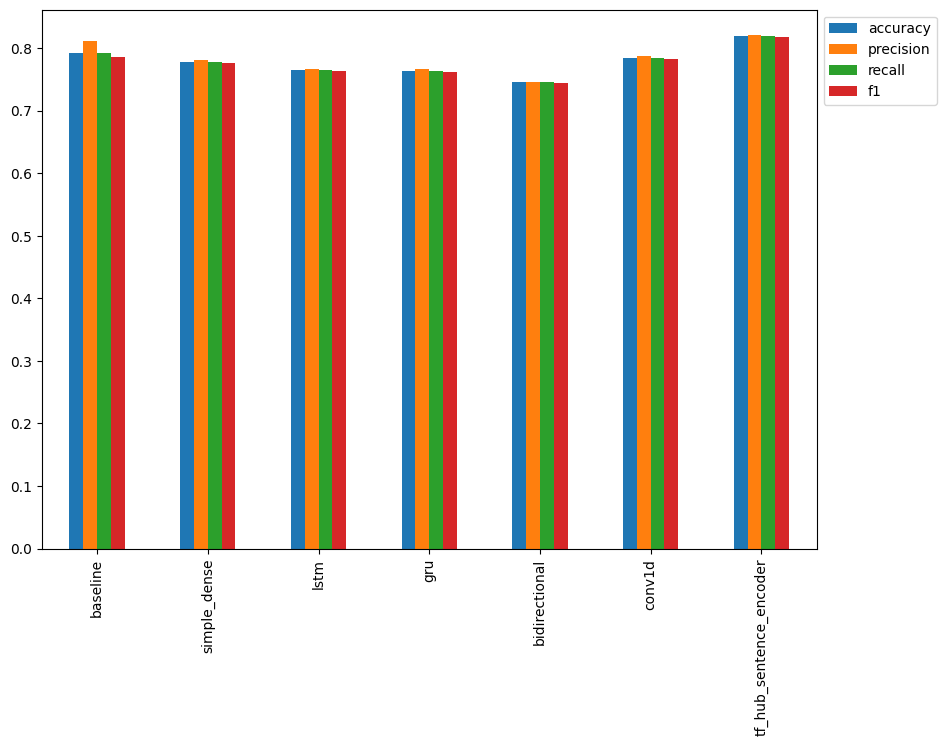

In [111]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100;
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

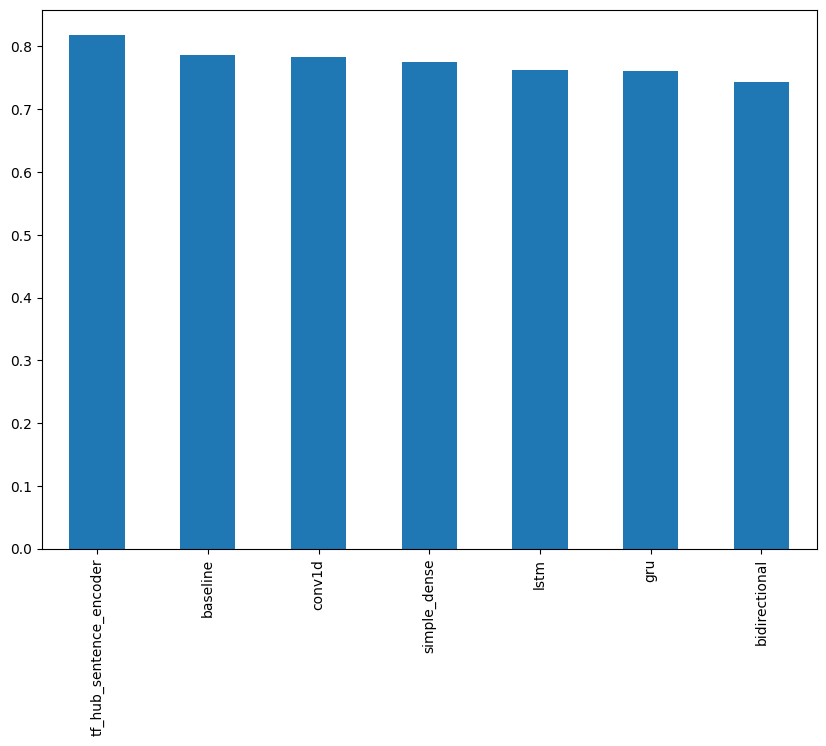

In [112]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

#Ensembling our models

In [113]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [114]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.92125984251969,
 'precision': 0.7989657478091081,
 'recall': 0.7992125984251969,
 'f1': 0.7989768992638423}

In [115]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [116]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

<ipython-input-116-5bfc9ea95ee8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [117]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.778215,0.781410,0.778215,0.775608
lstm,0.765092,0.766007,0.765092,0.763281
gru,0.763780,0.766626,0.763780,0.760927
bidirectional,0.745407,0.745282,0.745407,0.744009
conv1d,0.784777,0.786763,0.784777,0.782825
tf_hub_sentence_encoder,0.818898,0.820309,0.818898,0.817731
ensemble_results,79.921260,0.798966,0.799213,0.798977


#Finding the most wrong examples

In [118]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_1_preds,
                       "pred_prob": tf.squeeze(model_1_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.333493
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.735085
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.997529
3,@camilacabello97 Internally and externally scr...,1,0.0,0.187171
4,Radiation emergency #preparedness starts with ...,1,0.0,0.098890


In [119]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.992051
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.985709
474,My phone looks like it was in a car ship airpl...,0,1.0,0.945853
606,Maid charged with stealing Dh30000 from police...,0,1.0,0.898053
682,A change in the State fire code prohibits gril...,0,1.0,0.879753
129,Drowning in Actavis suicide,0,1.0,0.875083
643,another day another excellent @_dangerousbeans...,0,1.0,0.846922
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.845181
126,??One night and we're gonna come and crash the...,0,1.0,0.829161
351,@BookTubeAThon A world in which people aren't ...,0,1.0,0.800411


In [120]:
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9920514822006226
Text:
åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo

----

Target: 0, Pred: 1, Prob: 0.9857094287872314
Text:
Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA

----

Target: 0, Pred: 1, Prob: 0.9458527565002441
Text:
My phone looks like it was in a car ship airplane accident. Terrible

----

Target: 0, Pred: 1, Prob: 0.8980534672737122
Text:
Maid charged with stealing Dh30000 from police officer sponsor http://t.co/y35qtVDSOH | https://t.co/qhUJAjCTR5

----

Target: 0, Pred: 1, Prob: 0.879753053188324
Text:
A change in the State fire code prohibits grills on decks at condos and apartment buildings.  Check with your... http://t.co/KE1ZS6NAml

----

Target: 0, Pred: 1, Prob: 0.8750830888748169
Text:
Drowning in Actavis suicide

----

Target: 0, Pred: 1, Prob: 0.8469218611717224
Text:
another day

In [121]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.033527474850416183
Text:
@DavidJordan88 @Stephanenny Except we don't know who started the riot or if it even makes sense to credit any particular individuals...

----

Target: 1, Pred: 0, Prob: 0.03343614190816879
Text:
@reriellechan HE WAS THE LICH KING'S FIRST CASUALTY BLOCK ME BACK I HATE YOU! http://t.co/0Gidg9U45J

----

Target: 1, Pred: 0, Prob: 0.03333664685487747
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

Target: 1, Pred: 0, Prob: 0.028467928990721703
Text:
#ClimateChange Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy Things A... http://t.co/czpDn9oBiT #Anarchy

----

Target: 1, Pred: 0, Prob: 0.02218005619943142
Text:
Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/ZPxE3fMYNG #LGBT

----

Target: 1, Pred: 0, Prob: 0.01444978080689907
Text:
Rand Paul's Debate Strategy 'demolish Some other bad ideas out there or point out maybe that 

#Making predicitions on the test dataset

In [132]:
import numpy as np
import random

test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
    # ✅ Convert to NumPy array before passing to the model
    test_input = np.array([test_sample], dtype=object)

    pred_prob = tf.squeeze(model_6.predict(test_input))  # Ensure proper input format
    pred = tf.round(pred_prob)

    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Pred: 1, Prob: 0.9884018301963806
Text:
Landslide in Italian Alps kills three: ROME (Reuters) - Three people were killed when a severe rainstorm in th... http://t.co/GX1UXeY57B

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Pred: 1, Prob: 0.9480841755867004
Text:
Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/KiXRcBNjLs

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Pred: 1, Prob: 0.9888690710067749
Text:
qtSZg mhtw4fnet

Suicide bomber kills 15 in Saudi security site mosque - Reuters

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Pred: 0, Prob: 0.1992054134607315
Text:
Please share and sign this petition to save wild horses in Arizona. http://t.co/3tsSXPHuFE

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Pred: 1, Prob: 0.7490931749343872
Text:
This time next week there will be absolute pandemonium in several homes around Westmeath with some carefully... http://t.co/nwfNxs

In [156]:
tweet = "My name is Balaji"

In [167]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  test_input = np.array([sentence], dtype=object)

  pred_prob = tf.squeeze(model_6.predict(test_input))  # Ensure proper input format and get prediction probability
  pred_label = tf.round(pred_prob)
  # ✅ Use pred_prob directly instead of pred_prob[0][0]
  # ✅ pred_prob is a scalar, so access it directly
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob}")
  print(f"Text:\n{sentence}")

In [168]:
predict_on_sentence(model=model_6, # use the USE model
                    sentence=tweet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Pred: 0.0 (not real disaster) Prob: 0.07323009520769119
Text:
My name is Balaji


In [172]:
tweet_1 = "Massive earthquake strikes downtown! Buildings collapsed, people trapped under debris! Urgent help needed!"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
tweet_2 = "Had an amazing weekend at the beach! The weather was perfect, and the sunset was breathtaking!"

In [173]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=tweet_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Pred: 1.0 (real disaster) Prob: 0.994615375995636
Text:
Massive earthquake strikes downtown! Buildings collapsed, people trapped under debris! Urgent help needed!


In [174]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=tweet_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Pred: 0.0 (not real disaster) Prob: 0.04251991957426071
Text:
Had an amazing weekend at the beach! The weather was perfect, and the sunset was breathtaking!
